# Tie contact 3d

Author(s): Jukka Aho

## Solid block

Geometry and mesh:

<div class="main_block" style="max-width: 800px;">
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-13-box_geom.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-13-box_bcs.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
</div>

In [1]:
using JuliaFEM
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: LinearElasticityProblem, DirichletProblem, get_connectivity, Quad4, Hex8, DirectSolver

In [2]:
mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/mesh.med")
#mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/twoelem_box.med")

INFO: Found 4 element sets: SYM23, SYM12, SYM13, LOAD


Dict{ASCIIString,Any} with 2 entries:
  "nodes"        => Dict(2=>[0.0,0.0,0.0],11=>[0.0,0.3333333333333333,1.0],39=>…
  "connectivity" => Dict(68=>(:QU4,:OTHER,[45,47,48,46]),2=>(:SE2,:OTHER,[9,10]…

In [5]:
# interior elements are of type HE8
field_problem = LinearElasticityProblem()
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :HE8 || continue
    element = Hex8(elcon)
    element["geometry"] = Vector{Float64}[mesh["nodes"][i] for i in get_connectivity(element)]
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    push!(field_problem, element)
end
# Neumann boundary condition, traction force -100 on Z direction for element set LOAD
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == :LOAD) || continue
    element = Quad4(elcon)
    element["geometry"] = Vector{Float64}[mesh["nodes"][i] for i in get_connectivity(element)]
    element["displacement traction force"] = Vector{Float64}[[0.0, 0.0, -100.0] for i=1:4]
    push!(field_problem, element)
end
info("created $(length(field_problem.elements)) elements.")

INFO: created 36 elements.


In [6]:
# boundary conditions
boundary_problem = DirichletProblem("displacement", 3)
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset in [:SYM23, :SYM12, :SYM13]) || continue
    element = Quad4(elcon)
    element["geometry"] = Vector{Float64}[mesh["nodes"][i] for i in get_connectivity(element)]
    if elset == :SYM23
        element["displacement 1"] = 0.0
    elseif elset == :SYM12
        element["displacement 3"] = 0.0
    elseif elset == :SYM13
        element["displacement 2"] = 0.0
    end
    push!(boundary_problem, element)
end
info("created $(length(boundary_problem.elements)) boundary elements.")

INFO: created 27 boundary elements.


In [7]:
solver = DirectSolver()
solver.name = "block"
solver.nonlinear_problem = false
#solver.method = :UMFPACK
solver.dump_matrices = true
push!(solver, field_problem)
push!(solver, boundary_problem)
call(solver, 0.0)

INFO: # of field problems: 1
INFO: # of boundary problems: 1
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1...
INFO: dim = 192
INFO: Assembling boundary problems...
INFO: Assembling boundary 1...
INFO: dumping matrices to disk, file = matrices_block_host_1_iteration_1.jld
INFO: Solving system
INFO: CHOLMOD: all dofs = 192
INFO: CHOLMOD: interior dofs = 144
INFO: CHOLMOD: boundary dofs = 48
INFO: CHOLMOD: displacement on boundary solved.
INFO: CHOLMOD: homogeneous dirichlet boundary
INFO: CHOLMOD: LDLt factorization done in 0.0012049674987792969 seconds
INFO: CHOLMOD: solved in 0.05479288101196289 seconds. norm = 0.5879447357921324
INFO: timing info for iteration:
INFO: boundary assembly       : 0.09608697891235352


(1,true)

INFO: field assembly          : 1.0157549381256104
INFO: dump matrices to disk   : 0.9569120407104492
INFO: solve problem           : 0.48387885093688965
INFO: update element data     : 0.01578807830810547
INFO: non-linear iteration    : 2.568441867828369
INFO: solver finished in 2.7200798988342285 seconds.


In [8]:
nid = 0
for (nid, coords) in mesh["nodes"]
    if isapprox(coords, [1.0, 1.0, 1.0])
        info("nid near corner = $nid")
        break
    end
end
nid

INFO: nid near corner = 7


7

In [9]:
using JuliaFEM.Test
known_value = [1/36, 1/36, -1/9]
for element in field_problem.elements
    i = indexin([nid], get_connectivity(element))[1]
    i != 0 || continue
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    info("displacement X = $(X[i]), u = $(u[i])")
    @test isapprox(u[i], known_value)
end

INFO: displacement X = [1.0,1.0,1.0], u = [0.027777777777777794,0.02777777777777784,-0.11111111111111129]
INFO: displacement X = [1.0,1.0,1.0], u = [0.027777777777777794,0.02777777777777784,-0.11111111111111129]


In [10]:
xdoc, xmodel = JuliaFEM.Postprocess.xdmf_new_model()
coll = JuliaFEM.Postprocess.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.Postprocess.xdmf_new_grid(coll; time=0.0)

Xg = Dict{Int64, Vector{Float64}}()
ug = Dict{Int64, Vector{Float64}}()
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    for (i, c) in enumerate(conn)
        Xg[c] = X[i]
        ug[c] = u[i]
    end
end
perm = sort(collect(keys(Xg)))
nodes = Vector{Float64}[Xg[i] for i in perm]
disp = Vector{Float64}[ug[i] for i in perm]
elements = []
for el in field_problem.elements
    isa(el, JuliaFEM.Core.Element{JuliaFEM.Core.Hex8}) || continue
    push!(elements, (:Hex8, get_connectivity(el)))
end
#elements
JuliaFEM.Postprocess.xdmf_new_mesh!(grid, nodes, elements)
JuliaFEM.Postprocess.xdmf_new_nodal_field!(grid, "displacement", disp)
JuliaFEM.Postprocess.xdmf_save_model(xdoc, "/tmp/foobar2.xmf");

INFO: XDFM: ndim = 192


<img src="http://results.juliafem.org/2015-12-13-box_results.png" width=300px style="float:left">

## Block divived to two parts

Block is now divided to two parts and meshes are tied using mortar method.

<div class="main_block" style="max-width: 800px;">
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-13-divided-block-geometry.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-13-divided-block-both-parts.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
</div>

In [1]:
using JuliaFEM
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: LinearElasticityProblem, DirichletProblem, get_connectivity,
                     Quad4, Hex8, LinearSolver, update
#mesh_lower = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/LOWER_BLOCK.med")
#mesh_upper = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/UPPER_BLOCK.med")
#mesh_lower = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCK_TWOELEM.med", "LOWER_BLOCK_SPARSE")
#mesh_upper = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCK_TWOELEM.med", "UPPER_BLOCK_SPARSE")
#mesh1 = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCK_SPARSE.med", "LOWER_BLOCK_SPARSE")
#mesh2 = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCK_SPARSE.med", "UPPER_BLOCK_SPARSE")
mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCKS.med")

INFO: Found 6 element sets: SYM23, SYM12, UPPER_TO_LOWER, LOAD, SYM13, LOWER_TO_UPPER


Dict{ASCIIString,Any} with 2 entries:
  "nodes"        => Dict(68=>[1.0,0.0,0.5],2=>[0.0,0.0,0.16666666666666666],89=…
  "connectivity" => Dict(11=>(:SE2,:OTHER,[4,13]),158=>(:QU4,:UPPER_TO_LOWER,[8…

In [2]:
# interior elements are of type HE8
field_problem = LinearElasticityProblem()

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :HE8 || continue
    element = Hex8(elcon)
    update(element, "geometry", mesh["nodes"])
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    #info("lower: add element with connectivity $elcon")
    push!(field_problem, element)
end

# Neumann boundary condition, traction force -100 on Z direction for element set LOAD
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == :LOAD) || continue
    element = Quad4(elcon)
    update(element, "geometry", mesh["nodes"])
    element["displacement traction force 3"] = -100.0
    push!(field_problem, element)
end
info("created $(length(field_problem.elements)) elements.")

INFO: created 39 elements.


In [3]:
# boundary conditions
boundary_problem = DirichletProblem("displacement", 3)

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset in [:SYM23, :SYM12, :SYM13]) || continue
    element = Quad4(elcon)
    update(element, "geometry", mesh["nodes"])
    if elset == :SYM23
        element["displacement 1"] = 0.0
    elseif elset == :SYM12
        element["displacement 3"] = 0.0
    elseif elset == :SYM13
        element["displacement 2"] = 0.0
    end
    push!(boundary_problem, element)
end
info("created $(length(boundary_problem.elements)) boundary elements.")

INFO: created 35 boundary elements.


### Creating tie contact
- define slave element surface (the one where integration happend)
- define potential master elements for slave elements

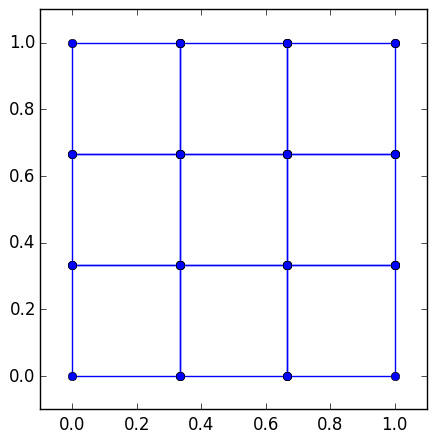

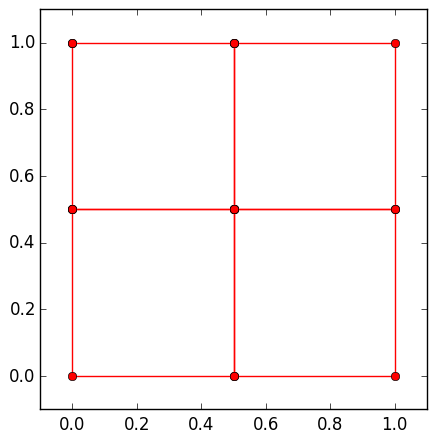

(-0.1,1.1)

In [4]:
using JuliaFEM.Core: Element, MortarProblem, calculate_normal_tangential_coordinates!

using PyPlot

mortar_surface = :LOWER_TO_UPPER
slave_surface = :UPPER_TO_LOWER

fig1 = figure(figsize=(5, 5))
master_elements = JuliaFEM.Core.Element[]
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == mortar_surface) || continue
    element = Quad4(elcon)
    update(element, "geometry", mesh["nodes"])
    X = element("geometry", 0.0)
    x = [X[mod(i, 4)+1][1] for i=1:5]
    y = [X[mod(i, 4)+1][2] for i=1:5]
    plot(x, y, "-bo")
    push!(master_elements, element)
end

xlim(-0.1, 1.1)
ylim(-0.1, 1.1)

fig1 = figure(figsize=(5, 5))
contact_problem = MortarProblem("displacement", 3)
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == slave_surface) || continue
    element = Quad4(elcon)
    update(element, "geometry", mesh["nodes"])
    element["master elements"] = master_elements
    X = element("geometry", 0.0)
    x = [X[mod(i, 4)+1][1] for i=1:5]
    y = [X[mod(i, 4)+1][2] for i=1:5]
    plot(x, y, "-ro")
    calculate_normal_tangential_coordinates!(element, 0.0)
    push!(contact_problem, element)
end
xlim(-0.1, 1.1)
ylim(-0.1, 1.1)

In [5]:
using JuliaFEM.Core: DirectSolver
solver = DirectSolver()
solver.name = "tie_contact_3d"
solver.method = :UMFPACK
solver.nonlinear_problem = false
solver.max_iterations = 1
solver.dump_matrices = true
push!(solver, field_problem)
push!(solver, boundary_problem)
push!(solver, contact_problem)
call(solver, 0.0)

INFO: # of field problems: 1
INFO: # of boundary problems: 2
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1...
INFO: dim = 273
INFO: Assembling boundary problems...
INFO: Assembling boundary 1...
INFO: Assembling boundary 2...
INFO: dumping matrices to disk, file = matrices_tie_contact_3d_host_1_iteration_1.jld
INFO: Solving system
INFO: UMFPACK: solved in 0.21015095710754395 seconds. norm = 0.5778929077881374
INFO: timing info for iteration:


(1,true)

INFO: boundary assembly       : 1.677372932434082
INFO: field assembly          : 1.1189799308776855
INFO: dump matrices to disk   : 1.127087116241455
INFO: solve problem           : 0.3656301498413086
INFO: update element data     : 0.024611949920654297
INFO: non-linear iteration    : 4.313704013824463
INFO: solver finished in 4.458410978317261 seconds.


In [6]:
prob = MortarProblem("temperature", 1)
ENV["COLUMNS"] = 160
ass = JuliaFEM.Core.Assembly()
el = contact_problem.elements[1]
push!(prob, el)
JuliaFEM.Core.assemble!(ass, prob, el, 0.0)
for (i, X) in enumerate(el("geometry", 0.0))
    ci = JuliaFEM.Core.get_connectivity(el)[i]
    @printf "%d %d %f %f %f\n" [i; ci; X]...
end
C = sparse(ass.stiffness_matrix)*46656
nz1 = sort(unique(rowvals(C)))
nz2 = sort(unique(rowvals(C')))
C = C[nz1,nz2]
CC = full(C);

1 84 1.000000 0.500000 0.500000
2 89 0.500000 0.500000 0.500000
3 69 0.500000 0.000000 0.500000
4 68 1.000000 0.000000 0.500000


In [9]:
for me in el["master elements"]
    
end

INFO: win
INFO: win
INFO: win
INFO: win
INFO: win
INFO: win
INFO: win
INFO: win
INFO: win


In [8]:
el("normal-tangential coordinates", 0.0)

JuliaFEM.Core.Field{JuliaFEM.Core.Discrete,JuliaFEM.Core.Variable,JuliaFEM.Core.TimeInvariant}(Array{T,2}[
3x3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0,

3x3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0,

3x3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0,

3x3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0])

In [7]:
CC

4x13 Array{Float64,2}:
 -784.0   -700.0   -28.0   -700.0   -28.0   -23.7  -0.5   -622.1   -23.7  1295.91    647.289   647.289  319.511
 -224.0  -1064.0  -224.0   -200.0    -8.0  -180.6  -2.2   -919.6   -27.6   647.289  1285.51    319.511  597.689
 -224.0   -200.0    -8.0  -1064.0  -224.0   -27.6  -2.2   -919.6  -180.6   647.289   319.511  1285.51   597.689
  -64.0   -304.0   -64.0   -304.0   -64.0  -186.6  -8.6  -1224.2  -186.6   319.511   597.689   597.689  891.111

In [24]:
using JuliaFEM.Test

nid = 0
for (nid, coords) in mesh["nodes"]
    if isapprox(coords, [1.0, 1.0, 1.0])
        info("nid near corner = $nid")
        break
    end
end
nid

known_value = [1/36, 1/36, -1/9]

for element in field_problem.elements
    i = indexin([nid], get_connectivity(element))[1]
    i != 0 || continue
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    info("displacement X = $(X[i]), u = $(u[i])")
    @test isapprox(u[i], known_value)
end

INFO: nid near corner = 73
INFO: displacement X = [1.0,1.0,1.0], u = [0.027468071147715937,0.02746807114771595,-0.11069400634503247]


Test Failed
  Expression: 

LoadError: LoadError: There was an error during testing
while loading In[24], in expression starting on line 14

isapprox(u[i],known_value)


In [7]:
[0.02952918548952522,0.0295291854895252,-0.11404135697110807]
[0.027468071147715937,0.02746807114771595,-0.11069400634503247]

3-element Array{Float64,1}:
  0.0274681
  0.0274681
 -0.110694 

In [7]:
xdoc, xmodel = JuliaFEM.Postprocess.xdmf_new_model()
coll = JuliaFEM.Postprocess.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.Postprocess.xdmf_new_grid(coll; time=0.0)

Xg = Dict{Int64, Vector{Float64}}()
ug = Dict{Int64, Vector{Float64}}()
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    for (i, c) in enumerate(conn)
        Xg[c] = X[i]
        ug[c] = u[i]
    end
end
perm = sort(collect(keys(Xg)))
nodes = Vector{Float64}[Xg[i] for i in perm]
disp = Vector{Float64}[ug[i] for i in perm]
elements = []
for el in field_problem.elements
    isa(el, JuliaFEM.Core.Element{JuliaFEM.Core.Hex8}) || continue
    push!(elements, (:Hex8, get_connectivity(el)))
end
#elements
JuliaFEM.Postprocess.xdmf_new_mesh!(grid, nodes, elements)
JuliaFEM.Postprocess.xdmf_new_nodal_field!(grid, "displacement", disp)
JuliaFEM.Postprocess.xdmf_save_model(xdoc, "/tmp/blocks.xmf");

INFO: XDFM: ndim = 273


<img src="http://results.juliafem.org/2015-12-14-divided-block-results.png"
         style="width:30%; height:auto; vertical-align:middle;">